In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [3]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [4]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

In [5]:
def ARMA(p, q, y_, res_, b=None):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    #----------------
    res = pd.DataFrame(list(res_), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
#     res_train_2 = res.fillna(0)
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    if b is None:
        lr = LinearRegression()
        lr.fit(X_train_ma,y_train_ma)

        theta_ma  = lr.coef_.T
        intercept_ma = lr.intercept_
    else:
        theta_ma = np.array(b)
        intercept_ma = 0

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma

    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
#     pred = list(prediction['Predicted_Values'])
    prediction = prediction.dropna()
    pred = [x for x in y_[:max(p,q)]] + list(prediction.Predicted_Values)

    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [6]:
def claculate_metrics_model_reg(y, y_pred, model_params):
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_arma_metric = {}
    model_arma_metric['r_squared'] = (np.var(y_pred)/np.var(y))**2# r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T,
                        columns=['r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [7]:
def claculate_metrics_model(y, y_pred, p, q, weight, window, params_ar, params_ma, intercept):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = (np.var(y_pred)/np.var(y))**2# r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid'] / len(y)) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [8]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

In [9]:
def show_prediction(y, y_pred, name):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y)
    plt.plot(y_pred)

## ARMA

In [10]:
file1 = open('2006rts1.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
(len(y))

248

## Зобразимо описові характеристики ряду

In [11]:
lags=40
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 248,
 'mode': 1190.34,
 'mean': 1545.9118951612907,
 'median': 1552.115,
 'variation': 24453.166410563863,
 'skewness': 0.1420579833187732,
 'kurtosis': -0.44372227972289036,
 'jarque-bera': 3.000356221871671,
 'probability': 0.22309042176581806}

In [12]:
y = pd.Series(y)
y.describe()

count     248.000000
mean     1545.911895
std       156.375082
min      1190.340000
25%      1429.807500
50%      1552.115000
75%      1641.837500
max      1921.920000
dtype: float64

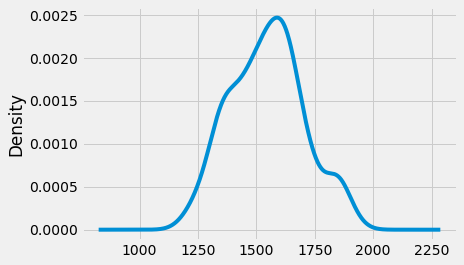

In [13]:
y.plot(kind='kde')

## Прологарифмуємо ряд

In [14]:
y = np.log(y)
y = pd.Series(y)

In [15]:
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 248,
 'mode': 7.081994259582736,
 'mean': 7.338256943811091,
 'median': 7.347373779077963,
 'variation': 0.01030062937038089,
 'skewness': -0.08793388111881964,
 'kurtosis': -0.47645363989598843,
 'jarque-bera': 2.806895389208736,
 'probability': 0.24574823683620872}

In [16]:
# diff_y = pd.Series(y).diff(periods=1).dropna()
# test = sm.tsa.adfuller(diff_y)
# y = np.array(diff_y).reshape(1,-1)[0]

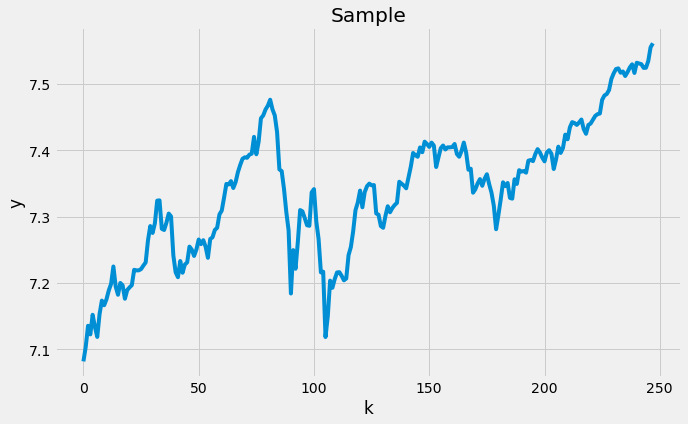

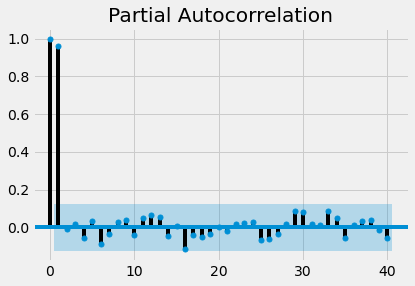

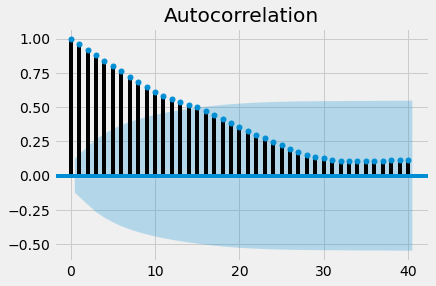

In [17]:
calculate_metrics_sample(y)
show_plots(y)

Із значення автокореляції обираємо p = 15

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [18]:
model = ARIMA(y, order=(15,0,0))
model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  248
Model:                    ARMA(15, 0)   Log Likelihood                 622.955
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 29 Oct 2020   AIC                          -1211.910
Time:                        13:45:40   BIC                          -1152.182
Sample:                             0   HQIC                         -1187.866
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3309      0.124     58.980      0.000       7.087       7.574
ar.L1.y        1.0489      0.063     16.562      0.000       0.925       1.173
ar.L2.y       -0.0113      0.091     -0.124      0.9

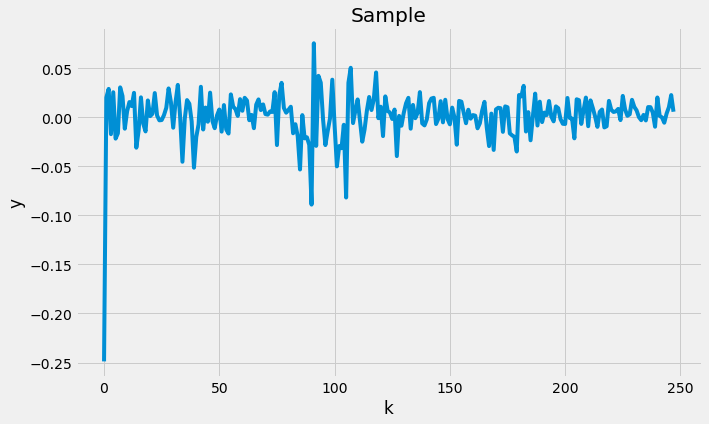

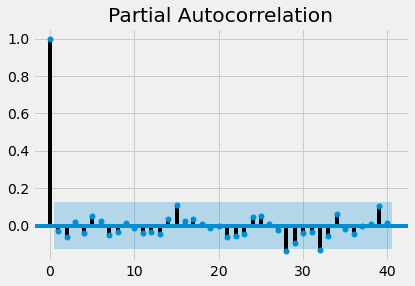

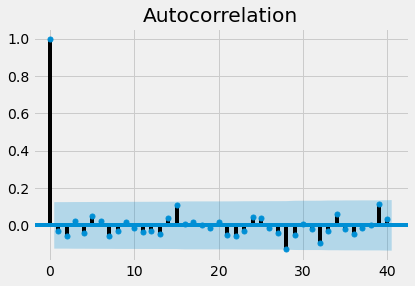

In [19]:
res =  model_fit.resid
show_plots(res)

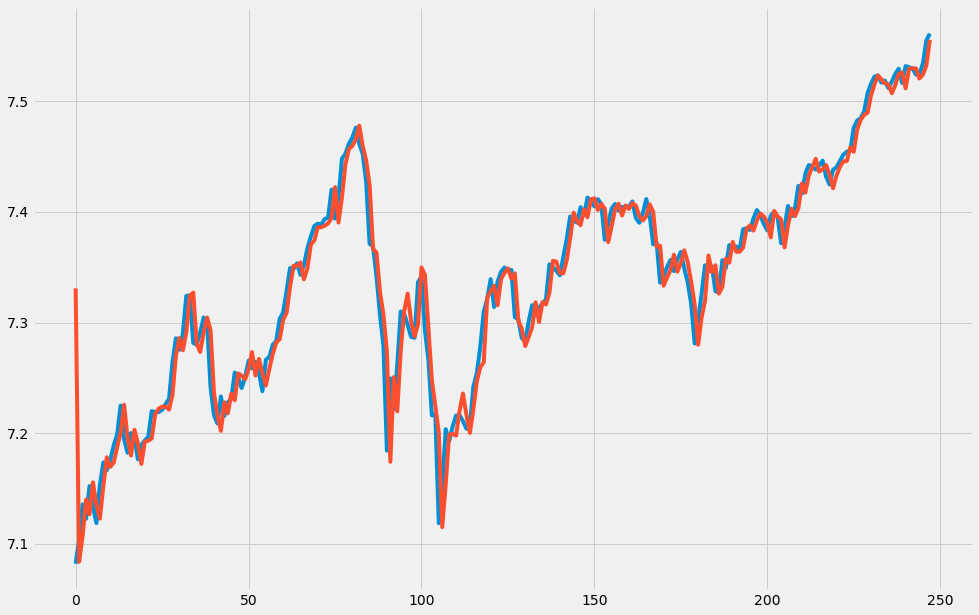

In [20]:
plt.figure(figsize= (15,10))

plt.plot(y)
plt.plot(np.array(model_fit.predict()))

In [21]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model = []

p, q = 15,28

mv5_simple = weight(res, weight='simple',window=5)
mv10_simple = weight(res, weight='simple',window=10)
mv5_epx = weight(res, weight='exponential',window=5)
mv10_epx = weight(res, weight='exponential',window=10)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple, mv5_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple, mv10_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_epx, mv5_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_epx, mv10_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)


## зообразимо отримані метрики готових моделей

In [22]:
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((15, 28)) simple:5",0.923549,0.14855,-1754.22,1.62988,"[[1.0409785754881546], [0.006079598611043137],...","[[0.951906395669136], [0.0363754888603398], [-...",[0.1009190144995181]
1,"ARMA((15, 28)) simple:10",0.917064,0.149117,-1753.28,1.64708,"[[1.0404188748681162], [-0.0024817125027411925...","[[0.9329792865024258], [0.04734731011651085], ...",[0.11115189041272341]
2,"ARMA((15, 28)) exponential:5",0.915556,0.146126,-1758.3,1.62738,"[[1.1910223219448606], [-0.06173194780092641],...","[[0.648366955697642], [0.01626223484280478], [...",[0.0863641597519134]
3,"ARMA((15, 28)) exponential:10",0.912064,0.147719,-1755.62,1.64712,"[[1.0826894324427436], [-0.009404285324468749]...","[[0.7775080626641545], [0.03478543379424216], ...",[0.09934924662544634]


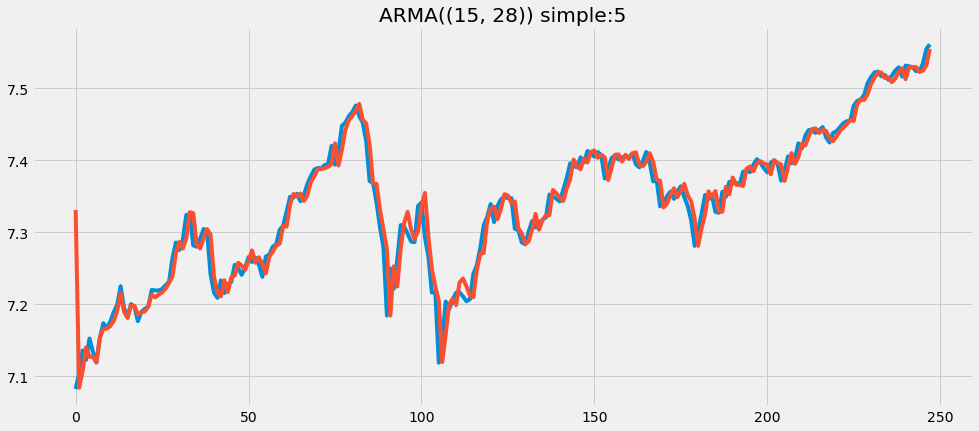

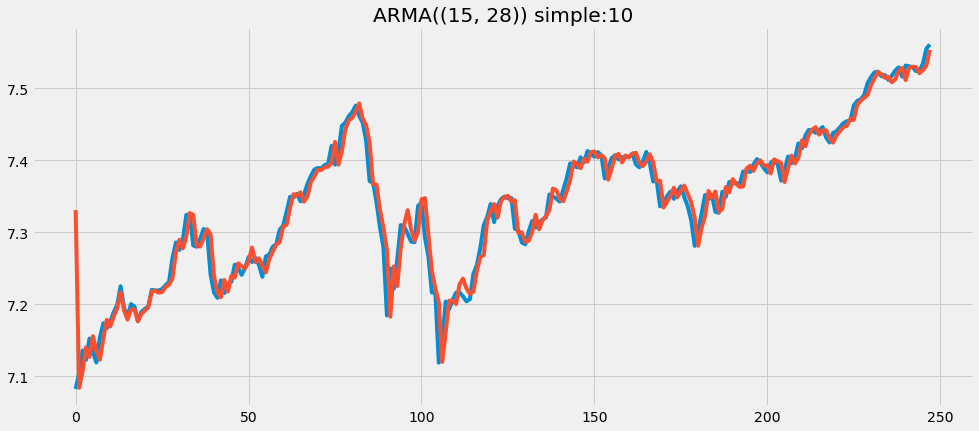

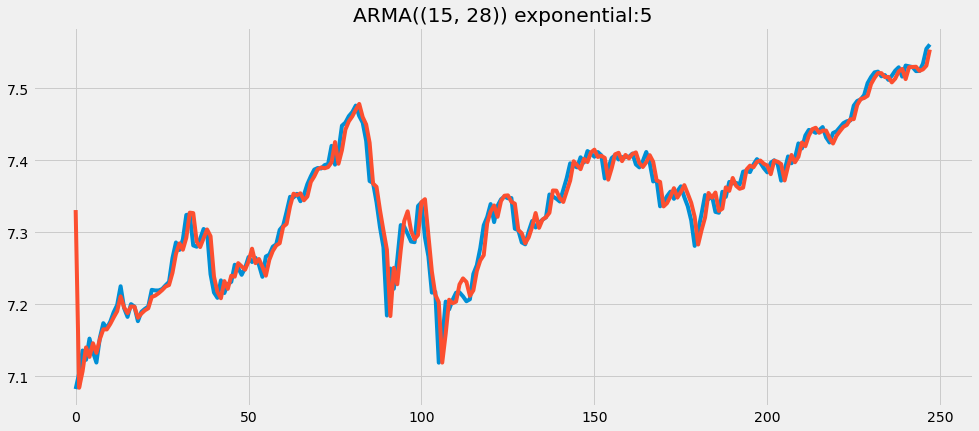

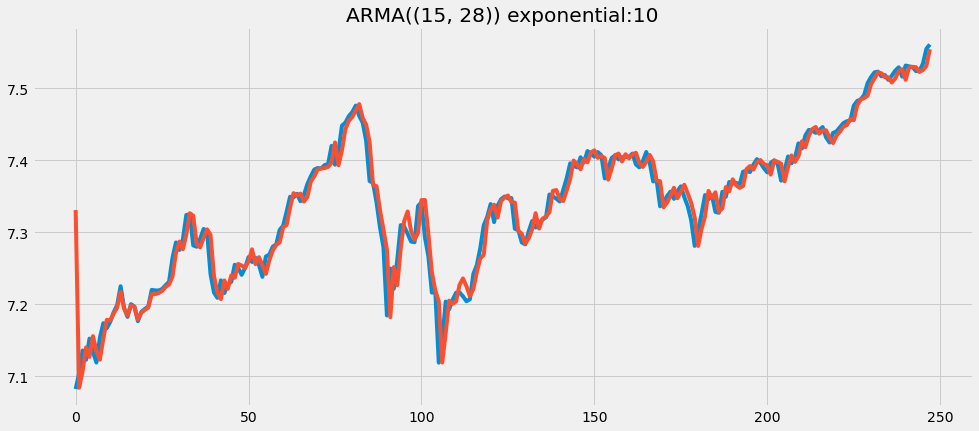

In [23]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y, y_pred, name)

In [24]:
models_metrics.to_excel('result/table_1.xls')

## 2. Побудова ARMA(p,q) коли КС будується по вихідному сигналу у 

## Власні коефіцієнти

In [25]:
def know_b(y, mv,q, window):
    a = 2/(window+1)
    s = sum([(1-a)**i for i in range(1, q+1)])
    b = [(1/s)*((1-a)**i) for i in range(1, q+1)]
    y_new = []
    for i in range(len(y)):
        s = y[i]-mv[i]
        
        for j in range(q):
            if( i - j -1 > -1):
                s += -mv[i-j-1]*b[j]
        y_new.append(s)
        
    return y_new, b

## продиференціюємо ряд, оскільки метод не працює з нестаціонарним рядо

In [26]:
diff_y = pd.Series(y).diff(periods=1).dropna()
test = sm.tsa.adfuller(diff_y)
y = np.array(diff_y).reshape(1,-1)[0]

# y = np.log(y)

calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 247,
 'mode': -0.09840337650819908,
 'mean': 0.0019396182419926127,
 'median': 0.003296006837254062,
 'variation': 0.00039985127918498536,
 'skewness': -1.0834406576202222,
 'kurtosis': 4.869438543996207,
 'jarque-bera': 279.67213235377596,
 'probability': 0.0}

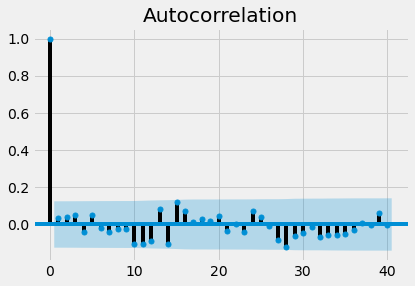

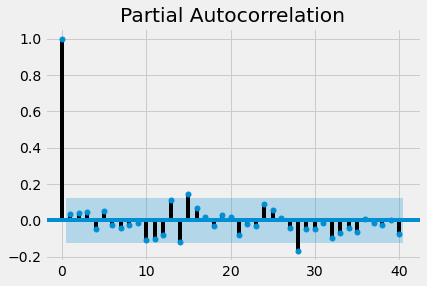

In [27]:
plot_acf(y, lags=lags);
plot_pacf(y, lags=lags);

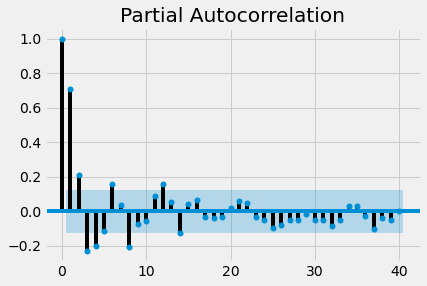

In [28]:
models_metrics_1 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_1 = []
window = 5
mv5_simple = weight(pd.DataFrame(y), weight='simple',window=window)

plot_pacf(pd.Series(mv5_simple[0]), lags=lags);

In [29]:
p,q=28, 14
y_new2, b2 = know_b(y, mv5_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_simple[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 14)) simple:5",0.0664663,0.0949866,-1858.26,2.07475,"[[0.2063322328984363], [0.09866354459721145], ...","[0.33447908722911684, 0.22298605815274458, 0.1...",[-0.0016873848675470313]


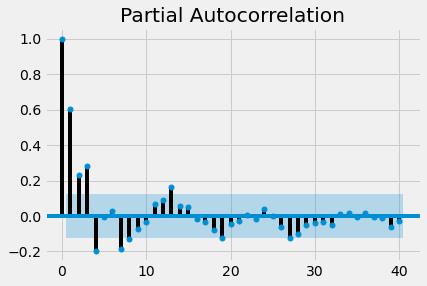

In [30]:
window = 10
mv10_simple = weight(pd.DataFrame(y), weight='simple',window=window)
plot_pacf(mv10_simple, lags=lags);

In [31]:
q=27
y_new2, b2 = know_b(y, mv10_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_simple[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 27)) simple:10",0.0492813,0.0913563,-1841.89,2.00046,"[[0.14544019075285208], [0.11919715568539212],...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-0.0016267434896891349]


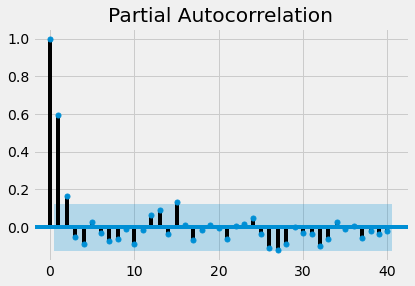

In [32]:
window = 5
mv5_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv5_exp, lags=lags);

In [33]:
q=27
y_new2, b2 = know_b(y, mv5_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_exp[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 27)) exponential:5",0.0349841,0.0925389,-1838.71,2.03062,"[[0.1240585200600778], [0.08049893137820084], ...","[0.3333392004185317, 0.2222261336123545, 0.148...",[-0.0015606818110499823]


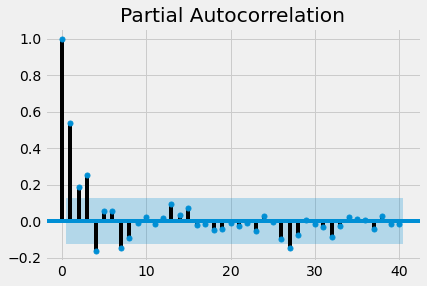

In [34]:
window = 10
mv10_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv10_exp, lags=lags);

In [35]:
q=27
y_new2, b2 = know_b(y, mv10_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_exp[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 27)) exponential:10",0.0278838,0.0897904,-1846.16,1.94818,"[[0.09134041281933543], [0.0783160807885781], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-0.0015878951583540256]


## зообразимо отримані метрики готових моделей

In [36]:
models_metrics_1

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 14)) simple:5",0.0664663,0.0949866,-1858.26,2.07475,"[[0.2063322328984363], [0.09866354459721145], ...","[0.33447908722911684, 0.22298605815274458, 0.1...",[-0.0016873848675470313]
1,"ARMA((28, 27)) simple:10",0.0492813,0.0913563,-1841.89,2.00046,"[[0.14544019075285208], [0.11919715568539212],...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-0.0016267434896891349]
2,"ARMA((28, 27)) exponential:5",0.0349841,0.0925389,-1838.71,2.03062,"[[0.1240585200600778], [0.08049893137820084], ...","[0.3333392004185317, 0.2222261336123545, 0.148...",[-0.0015606818110499823]
3,"ARMA((28, 27)) exponential:10",0.0278838,0.0897904,-1846.16,1.94818,"[[0.09134041281933543], [0.0783160807885781], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-0.0015878951583540256]


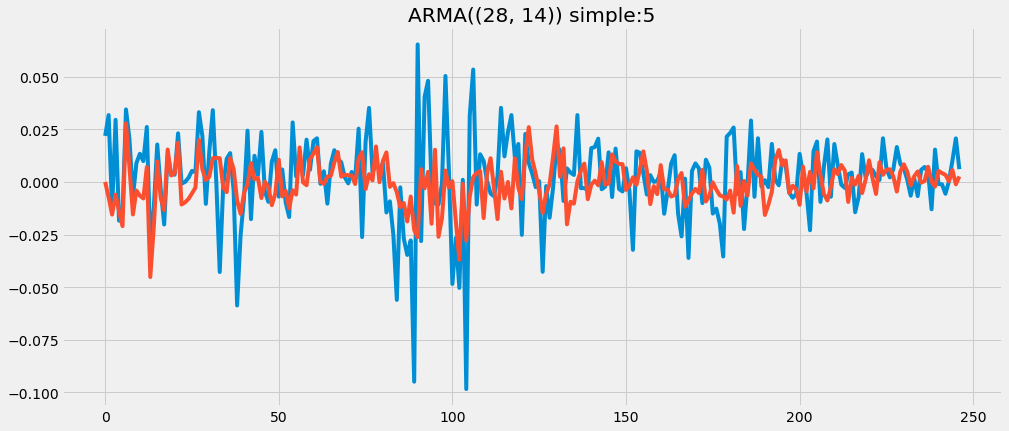

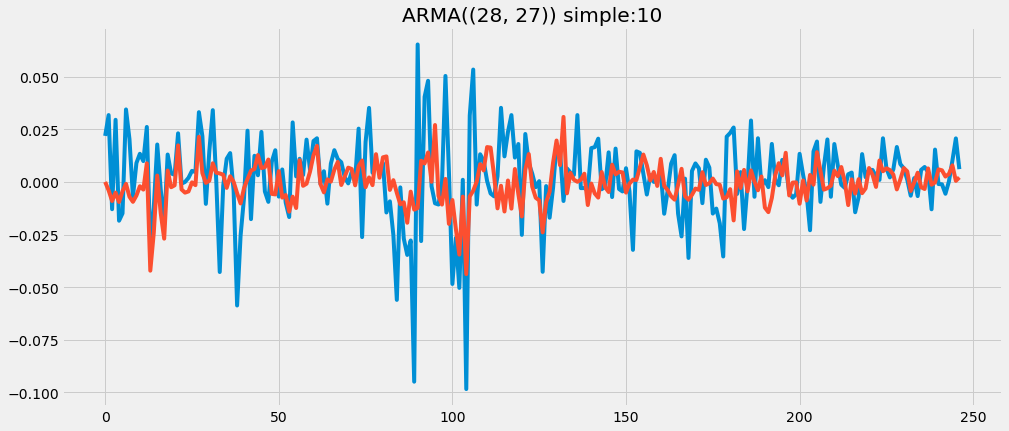

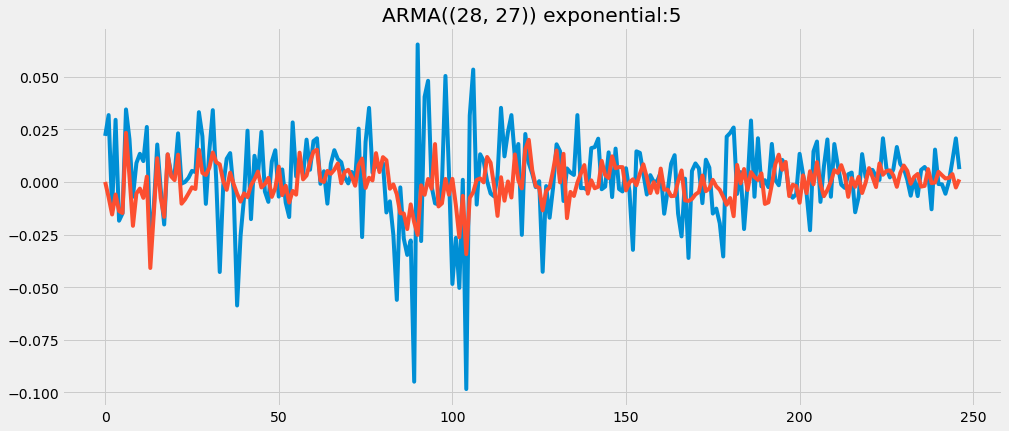

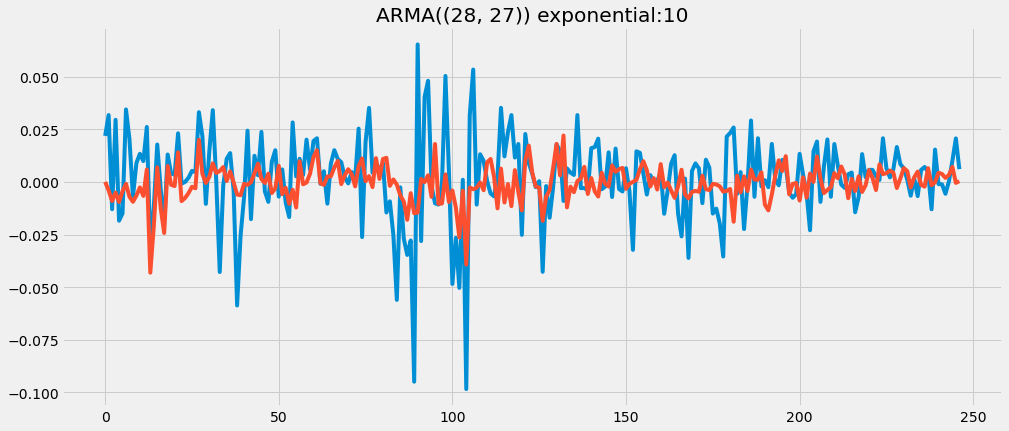

In [37]:
for name, y_pred in zip(models_metrics_1.name, predictions_model_1):
    show_prediction(y, y_pred, name)

In [38]:
models_metrics_1.to_excel('result/table_2.xls')

## Обчислення коефіцієнтів 

In [39]:
models_metrics_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_2 = []

q = 14
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple[0], mv5_simple[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple[0], mv10_simple[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_exp[0], mv5_exp[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_exp[0], mv10_exp[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

## зообразимо отримані метрики готових моделей

In [40]:
models_metrics_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((28, 14)) simple:5",0.0355718,0.0844596,-1887.28,1.99464,"[[-0.16358585523454855], [-0.2004281625570724]...","[[0.9683329278693582], [0.03979952539395206], ...",[0.00033011735952476765]
1,"ARMA((28, 27)) simple:10",0.0315044,0.0847669,-1860.38,2.02511,"[[-0.021450025231264415], [-0.0227732760142443...","[[1.0029956282094572], [0.019805091523623357],...",[0.0002206613613928009]
2,"ARMA((28, 27)) exponential:5",0.0273602,0.0828162,-1866.13,2.02929,"[[-0.24516190373544164], [-0.21351987762753963...","[[0.7112466232901606], [0.016553598352268595],...",[0.0005912966087722035]
3,"ARMA((28, 27)) exponential:10",0.0282932,0.0840992,-1862.33,2.0267,"[[-0.09134846596129965], [-0.0756496347830743]...","[[0.8507098759838756], [0.01828085862855427], ...",[0.0003622611460585912]


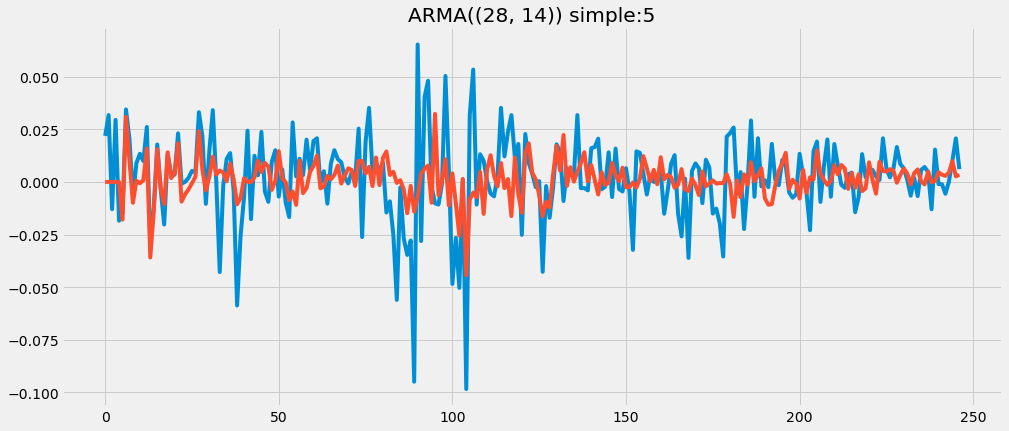

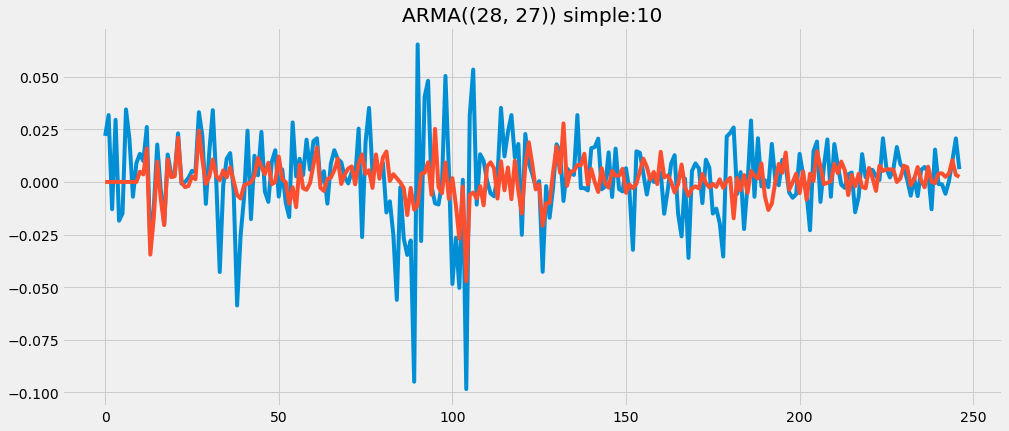

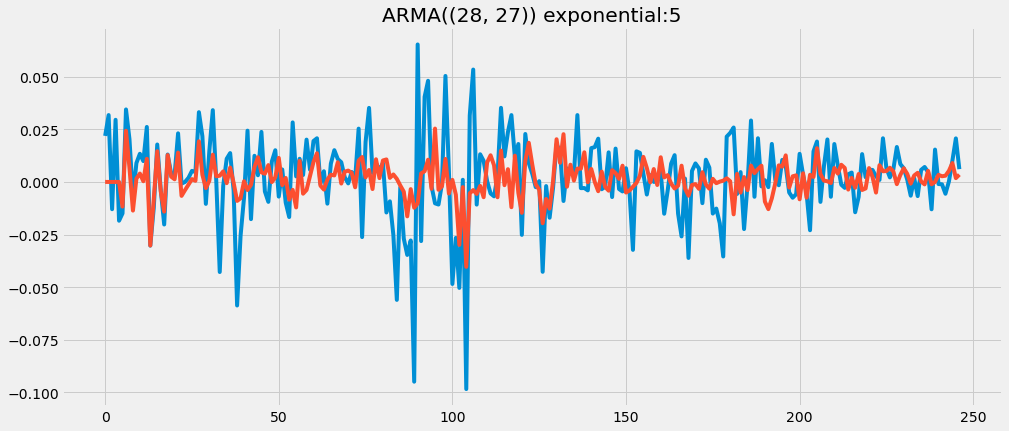

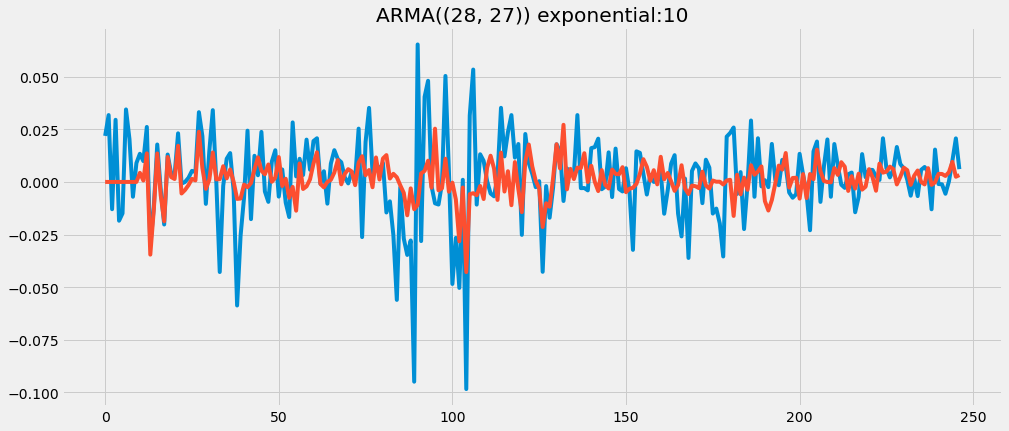

In [42]:
for name, y_pred in zip(models_metrics_2.name, predictions_model_2):
    show_prediction(y, y_pred, name)

In [43]:
models_metrics_2.to_excel('result/table_3.xls')

# Multiple regression

In [44]:
df_train = pd.read_excel('ATS_lab_03_new/Data/xls/Full_Data.xls')

In [45]:
df_train.shape

(178, 10)

In [46]:
df_train.head()

,<DTYYYYMMDD>,RTSI,RTS2,RTSog,RTStl,RTSmm,RTSin,RTScr,RTSeu,RTSfn
0,20080109,2296.56,2632.20,288.90,322.85,363.97,408.62,374.12,465.29,786.31
1,20080110,2306.87,2642.20,289.56,322.59,368.81,409.33,376.17,463.22,788.79
2,20080111,2313.90,2651.62,289.20,324.09,369.50,413.30,380.34,463.92,792.27
3,20080114,2339.79,2652.71,293.30,328.12,376.52,414.34,382.76,465.09,796.21
4,20080115,2330.87,2670.61,291.39,328.72,376.05,417.96,386.37,468.23,793.43


In [47]:
df_train = df_train.drop(['<DTYYYYMMDD>'],axis=1)

In [48]:
df_train.describe()

,RTSI,RTS2,RTSog,RTStl,RTSmm,RTSin,RTScr,RTSeu,RTSfn
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,2043.537303,2383.844326,265.259888,262.411854,359.151966,392.829326,325.120730,352.207472,623.623652
std,289.921448,290.307690,39.371808,30.039644,57.078046,54.309037,33.461727,62.913200,88.704163
min,1058.840000,1441.950000,147.400000,158.390000,194.270000,246.140000,216.760000,169.920000,309.390000
25%,1947.650000,2396.500000,241.652500,258.902500,329.405000,378.690000,324.467500,312.975000,604.335000
50%,2068.170000,2483.955000,264.100000,269.525000,374.025000,414.835000,334.860000,362.815000,633.670000
75%,2220.542500,2576.405000,293.075000,278.355000,402.762500,430.002500,344.987500,403.910000,678.172500
max,2487.920000,2670.610000,334.230000,328.720000,442.990000,450.600000,386.370000,468.230000,796.210000


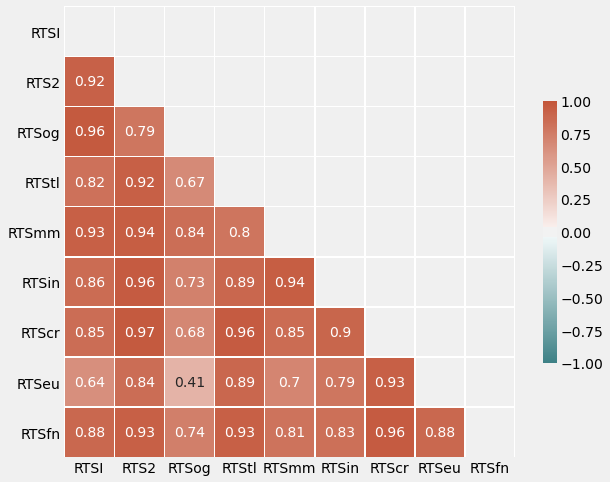

In [49]:
correlation = df_train.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9, 9))

cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5,cbar_kws={'shrink': .5}, annot=True)

plt.show()

## Оскільки всі регресори моделі мають високу кореляцію з 'rts1', використовуємо всі

In [50]:
rts1 = df_train.RTSI
df_train = df_train.drop(['RTSI'], axis=1)

In [51]:
reg = LinearRegression().fit(df_train.values, rts1)
pred = df_train.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rts1, pred, len(df_train.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.998603,10395.684492,1662.347996,0.472749


## Спробуємо покращити модель взявши логарифм

In [52]:
df_train_log = np.log(df_train)
rst1_log = np.log(rts1)

reg = LinearRegression().fit(df_train_log.values, rst1_log)
pred = df_train_log.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rst1_log, pred, len(df_train_log.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.998607,0.003144,-1009.662515,0.673829


#### Бачимо що отримали кращі результати в метриках 

## Врахуємо залежність між попередніми координатами

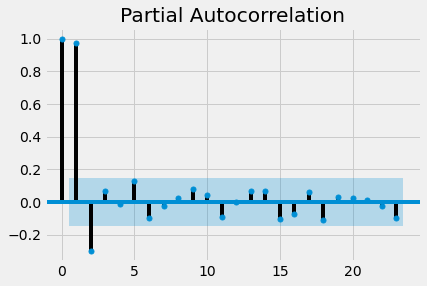

In [53]:
plot_pacf(rts1);

In [54]:
df_shift = df_train.copy()
p = 2
df_rts = pd.DataFrame(rts1, columns=['Value'])
for i in range(1,p+1):
        df_shift[f'Shifted_values_{i}'] = df_rts['Value'].shift(i)

df_shift = df_shift.fillna(0)
reg = LinearRegression().fit(df_shift.values, rts1)
pred = df_shift.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rts1, pred, len(df_shift.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.998603,10395.684492,1666.347996,0.472749


### Coefficients

In [55]:
print(f'intercept:\t{reg.intercept_:e}')
print(f'coeff: \n{reg.coef_ }')

intercept:	-5.026886e+01
coeff: 
[ 0.05360143  4.10400701  0.69963745  1.2086222  -0.19721911 -0.46968547
  0.02216155  0.77306325  0.          0.        ]
